In [1]:
# Math Packages
import numpy as np
import torch as torch
from scipy import interpolate
from scipy.optimize import minimize
from scipy.interpolate import make_interp_spline
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.stats import norm

# Plotting
import matplotlib.pyplot as plt  
from matplotlib.pyplot import figure
from matplotlib import cm
#matplotlib format
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

# Data saving packages
from pickle import dump, load
import itertools 

In [2]:
print("Loading experimental data...")
input_dict = load(open('exp_data/experimental_data_NEW.p', 'rb'))
xs_exp = torch.tensor(input_dict['exp_params'])
sqs_exp = torch.tensor(input_dict['sqs'])
rdfs_exp = torch.tensor(input_dict['rdfs'])
print("Success!!!")
print(xs_exp)

import pandas as pd
df = pd.read_csv('exp_data/plot-data.csv')
ρ_vle = df.to_numpy()[:,0]
T_vle = df.to_numpy()[:,1]
# print(ρ_vle[0])

Loading experimental data...
Success!!!
tensor([[1.8502, 0.8571],
        [1.8502, 0.7965],
        [1.8502, 0.7438],
        [1.8502, 0.6977],
        [1.8925, 0.8571],
        [1.8925, 0.7965],
        [1.8925, 0.7438],
        [1.8925, 0.6977],
        [1.9330, 0.8571],
        [1.9330, 0.7965],
        [1.9330, 0.7438],
        [1.9330, 0.6977],
        [1.9718, 0.8571],
        [1.9718, 0.7965],
        [1.9718, 0.7438],
        [1.9718, 0.6977],
        [1.7291, 0.8010],
        [1.8614, 0.9102],
        [1.9428, 1.0521]], dtype=torch.float64)


In [3]:
ids       = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
uncs      = [0,1,2,3,4,5]
noise_arr = [0.005, 0.0075, 0.01, 0.02, 0.05, 0.1]

# print(xs_exp[ids])

mcmc_n  = list()
mcmc_σ  = list()
mcmc_ϵ  = list()
mcmc_σn = list()

for i in range (len(uncs)):
    mcmc_n_sub  = []
    mcmc_σ_sub  = []
    mcmc_ϵ_sub  = []
    mcmc_σn_sub = []
    for j in range (len(ids)):
        input_dict = load(open('results/reactor_pickle_NEW/exp_' + str(ids[j]) + 'unc_' + str(uncs[i]) +'.p', 'rb'))
        mcmc = input_dict['mcmc']
        #remove pathological samples from numerical instability
        mcmc = mcmc[np.exp(mcmc.T[0]) + 6 - np.array(xs_exp[ids[j],[0]]) > -6.1]
        if i <= 3:
            mcmc = mcmc[np.exp(mcmc.T[0]) + 6 - 12 > -4]
            mcmc = mcmc[np.exp(mcmc.T[0]) + 6 - 12 < 4]
        mcmc_n_sub.append(np.exp(mcmc.T[0]) + 6 - 12)
        mcmc_σ_sub.append(np.exp(mcmc.T[1]) - np.array(xs_exp[ids[j],[0]]))
        mcmc_ϵ_sub.append(np.exp(mcmc.T[2]) - np.array(xs_exp[ids[j],[1]]))
        mcmc_σn_sub.append(np.exp(mcmc.T[3])/2)
    mcmc_n.append(mcmc_n_sub)
    mcmc_σ.append(mcmc_σ_sub)
    mcmc_ϵ.append(mcmc_ϵ_sub) 
    mcmc_σn.append(mcmc_σn_sub)
        
#         plt.hist(np.exp(mcmc.T[2]) - np.array(xs_exp[ids[j],[2]]), bins = histbins_ϵ, density = True, label = ids[j], alpha = 0.8)
#         plt.legend()
#         plt.show()

Number of Experiments: 19


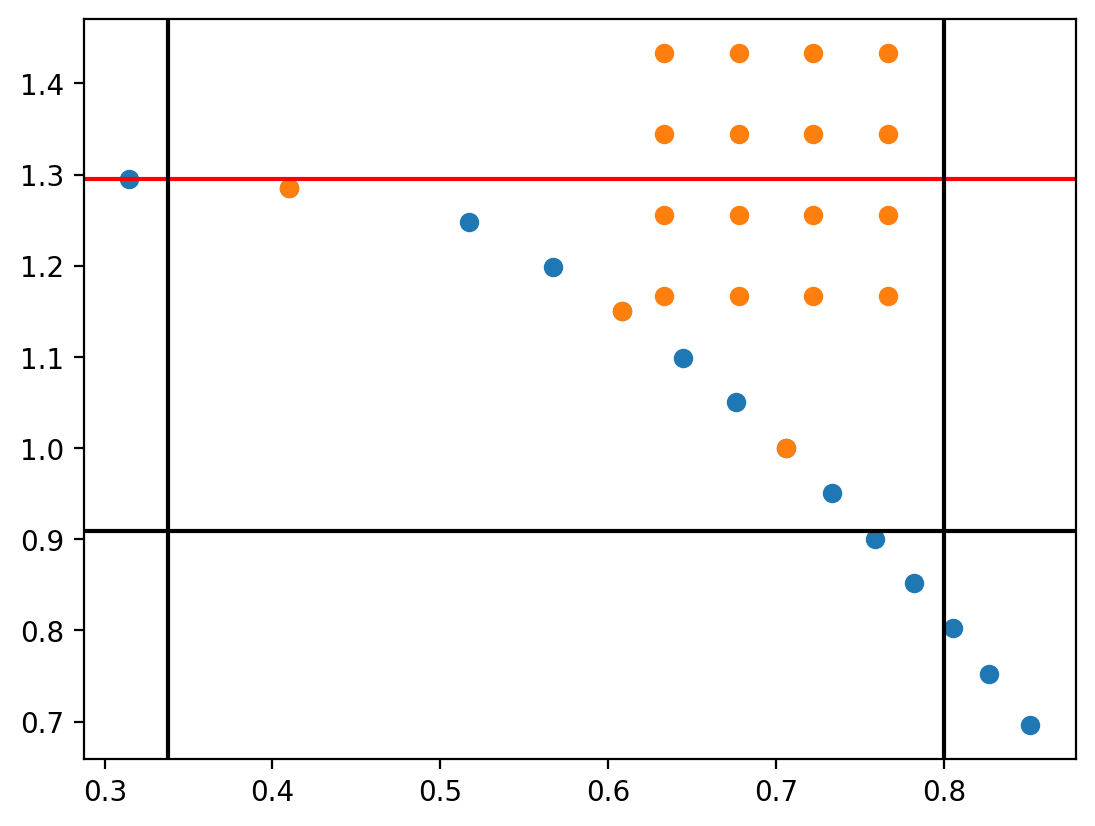

In [6]:
rho_points = 0.1*xs_exp[ids,[0]]**3
T_points   = 1/xs_exp[ids,[1]]

# print(rho_points)
# print(T_points)

#defined on rho^* T^*
ranges = np.array([[0.6, 0.8],
                   [1.1, 1.5]])

num = 4
n   = 12
#n_range = np.linspace(ranges[0,0] + (ranges[0,1] - ranges[0,0])/6 ,ranges[0,1] - (ranges[0,1] - ranges[0,0])/6,num)
σ_range = np.linspace(ranges[0,0] + (ranges[0,1] - ranges[0,0])/6 ,ranges[0,1] - (ranges[0,1] - ranges[0,0])/6,num)
ϵ_range = np.linspace(ranges[1,0] + (ranges[1,1] - ranges[1,0])/6 ,ranges[1,1] - (ranges[1,1] - ranges[1,0])/6,num)

# print((σ_range/0.1)**(1/3))

exp_params = []

# for n in n_range:
for σ in σ_range:
    for ϵ in ϵ_range:
        exp_params.append([n,σ,ϵ])
exp_params.append([12, ρ_vle[1], T_vle[1]])
exp_params.append([12, ρ_vle[4], T_vle[4]])
exp_params.append([12, ρ_vle[7], T_vle[7]])
print("Number of Experiments:", len(exp_params))

#plt.scatter(rho_points, T_points)
plt.scatter(ρ_vle, T_vle)
plt.scatter(np.array(exp_params).T[1], np.array(exp_params).T[2])
plt.axhline(T_vle[0], color = 'r')
plt.axvline(0.1*2**3, color = 'k')
plt.axvline(0.1*1.5**3, color = 'k')
plt.axhline(1/1.1, color = 'k')
# plt.axhline(1/0.1, color = 'k')
plt.xlim()
plt.show()

In [9]:
# print((np.array(exp_params).T[1]/0.1)**(1/3))
# print(1/(np.array(exp_params).T[2]))

exp_params_mie = [(np.array(exp_params).T[1]/0.1)**(1/3), 1/(np.array(exp_params).T[2])]
exp_params_mie = (np.array(exp_params_mie).T)

# print(exp_params_mie)

In [11]:
plasma = cm.get_cmap('plasma', len(uncs))
newcolors = plasma(np.linspace(0, 1, len(uncs)))

/var/folders/q1/9ty2s0rx2yz1wym60b_0f58c0000gn/T/ipykernel_68312/3114731138.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = cm.get_cmap('plasma', len(uncs))


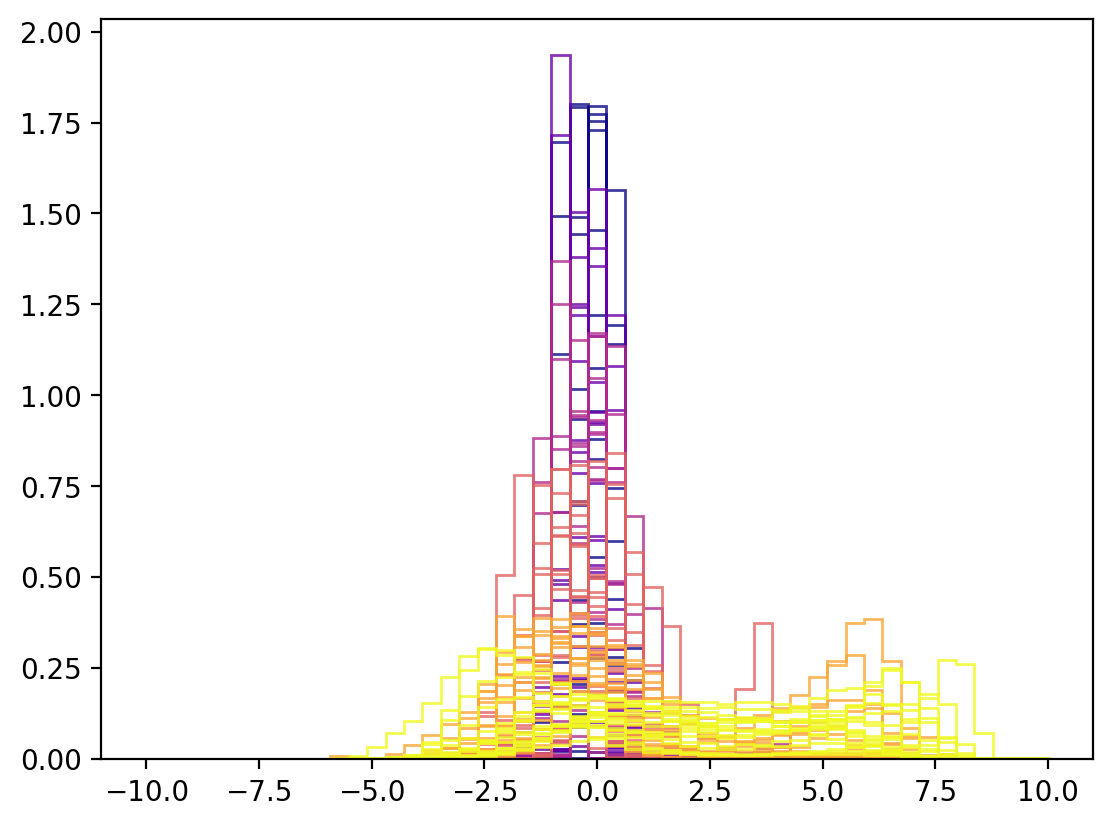

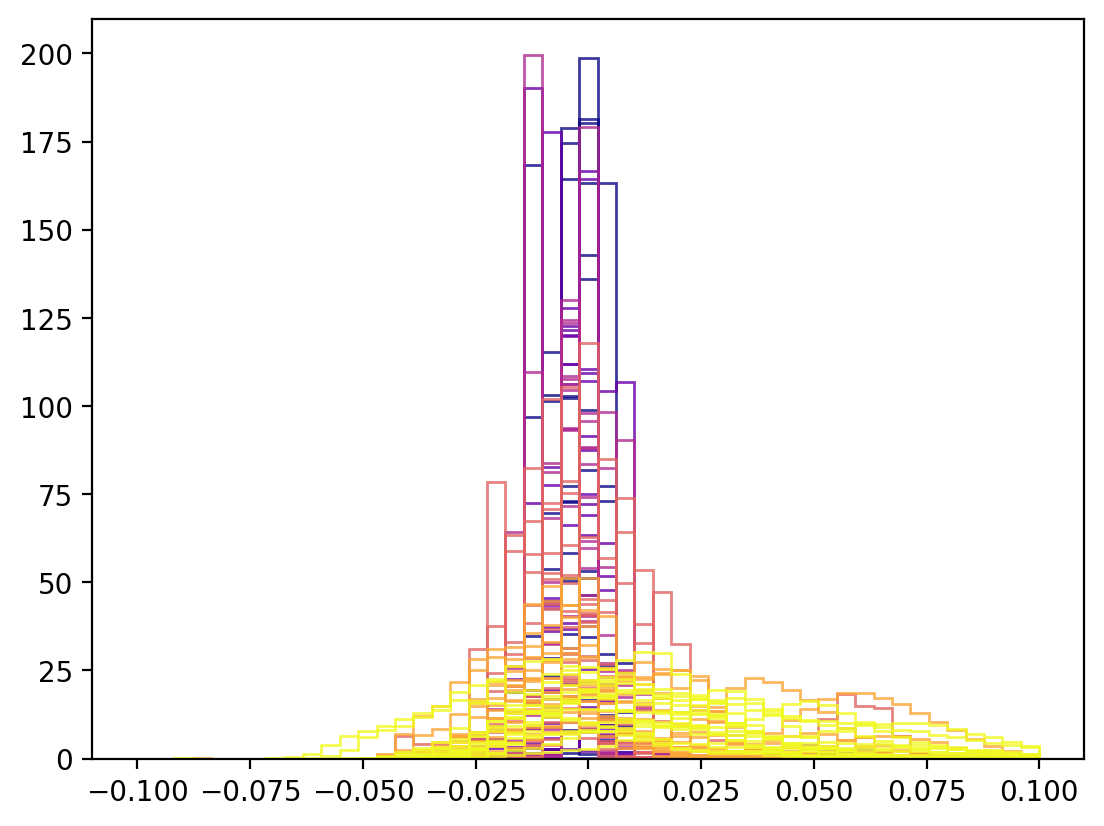

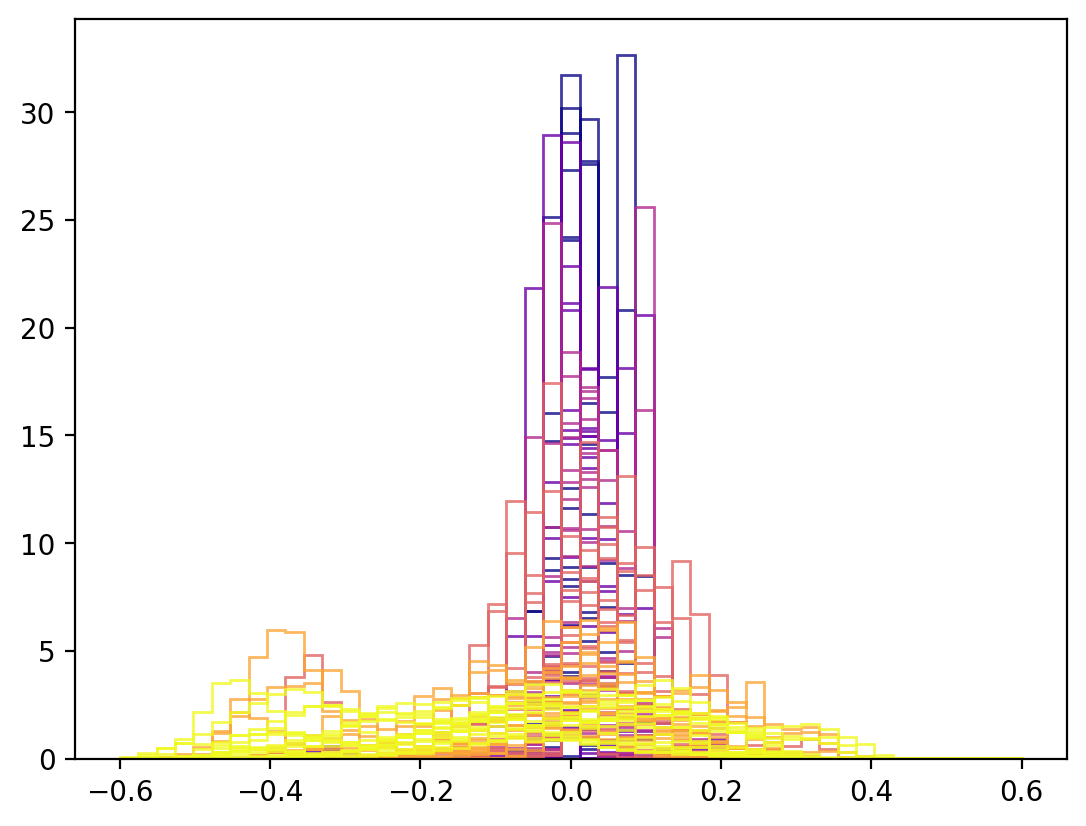

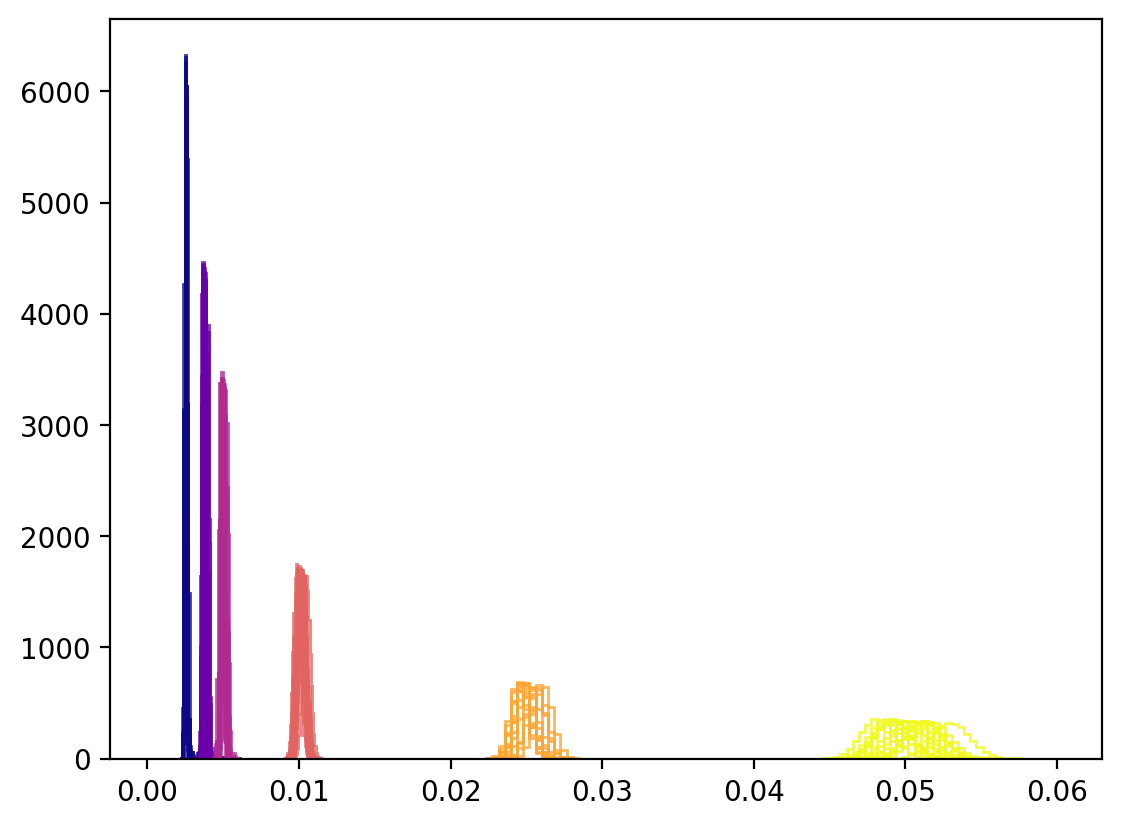

In [13]:
n_arr = []
histbins_n = np.linspace(-10, 10, 50)
n_maps = list()
n_var = list()
for i in range (len(uncs)):
    for j in range (len(ids)):
        mcmc_n_conc = mcmc_n[i][j]
        
        n,bins,patches = plt.hist(mcmc_n_conc, bins = histbins_n, density = True, label = noise_arr[i], alpha = 0.8, 
                 color = newcolors[i], histtype = 'step')
        midsn = 0.5*(bins[1:] + bins[:-1])
        
        try:
            n_sum += n/len(mcmc_n_conc)
        except:
            n_sum = n/len(mcmc_n_conc)
    
    n_arr.append(n_sum/len(ids))
    n_sum = "bug7"
    
plt.show()

σ_arr = []
histbins_σ = np.linspace(-0.1, 0.1, 50)
σ_maps = list()
σ_var = list()
for i in range (len(uncs)):
    for j in range (len(ids)):
        mcmc_σ_conc = mcmc_σ[i][j]
        
        sig,bins,patches = plt.hist(mcmc_σ_conc, bins = histbins_σ, density = True, label = noise_arr[i], alpha = 0.8, 
                 color = newcolors[i], histtype = 'step')
        midsσ = 0.5*(bins[1:] + bins[:-1])
        
        try:
            σ_sum += sig/len(mcmc_σ_conc)
        except:
            σ_sum = sig/len(mcmc_σ_conc)
    
    σ_arr.append(σ_sum/len(ids))
    σ_sum = "bug7"
    
plt.show()

ϵ_arr = []
histbins_ϵ = np.linspace(-0.6, 0.6, 50)
ϵ_maps = list()
ϵ_var = list()
for i in range (len(uncs)):
    for j in range (len(ids)):
        mcmc_ϵ_conc = mcmc_ϵ[i][j]
        
        eps,bins,patches = plt.hist(mcmc_ϵ_conc, bins = histbins_ϵ, density = True, label = noise_arr[i], alpha = 0.8, 
                 color = newcolors[i], histtype = 'step')
        midsϵ = 0.5*(bins[1:] + bins[:-1])
        try:
            ϵ_sum += eps/len(mcmc_ϵ_conc)
        except:
            ϵ_sum = eps/len(mcmc_ϵ_conc)
    
    ϵ_arr.append(ϵ_sum/len(ids))
    ϵ_sum = "bug7"
    
plt.show()

σn_arr = []
histbins_σn = np.linspace(0.001, 0.06, 50)
middies = []
for i in range (len(uncs)):
    if i < 4:
        histbins_σn = np.linspace(noise_arr[i]/2 - 0.002 ,noise_arr[i]/2 + 0.002, 50)
        mcmc_σn_conc = mcmc_σn[i][j]
        
        eps,bins,patches = plt.hist(mcmc_σn_conc, bins = histbins_σn, density = True, label = noise_arr[i], alpha = 0.8, 
                 color = newcolors[i], histtype = 'step')
        midsσn = 0.5*(bins[1:] + bins[:-1])
    else:
        histbins_σn = np.linspace(noise_arr[i]/2 - 0.01 ,noise_arr[i]/2 + 0.01, 50)
    for j in range (len(ids)):
        mcmc_σn_conc = mcmc_σn[i][j]
        
        eps,bins,patches = plt.hist(mcmc_σn_conc, bins = histbins_σn, density = True, label = noise_arr[i], alpha = 0.8, 
                 color = newcolors[i], histtype = 'step')
        midsσn = 0.5*(bins[1:] + bins[:-1])
        
        try:
            ϵ_sum += eps/len(mcmc_σn_conc)
        except:
            ϵ_sum = eps/len(mcmc_σn_conc)
    middies.append(midsσn)
    σn_arr.append(ϵ_sum/len(ids))
    ϵ_sum = "bug7"
    
plt.show()

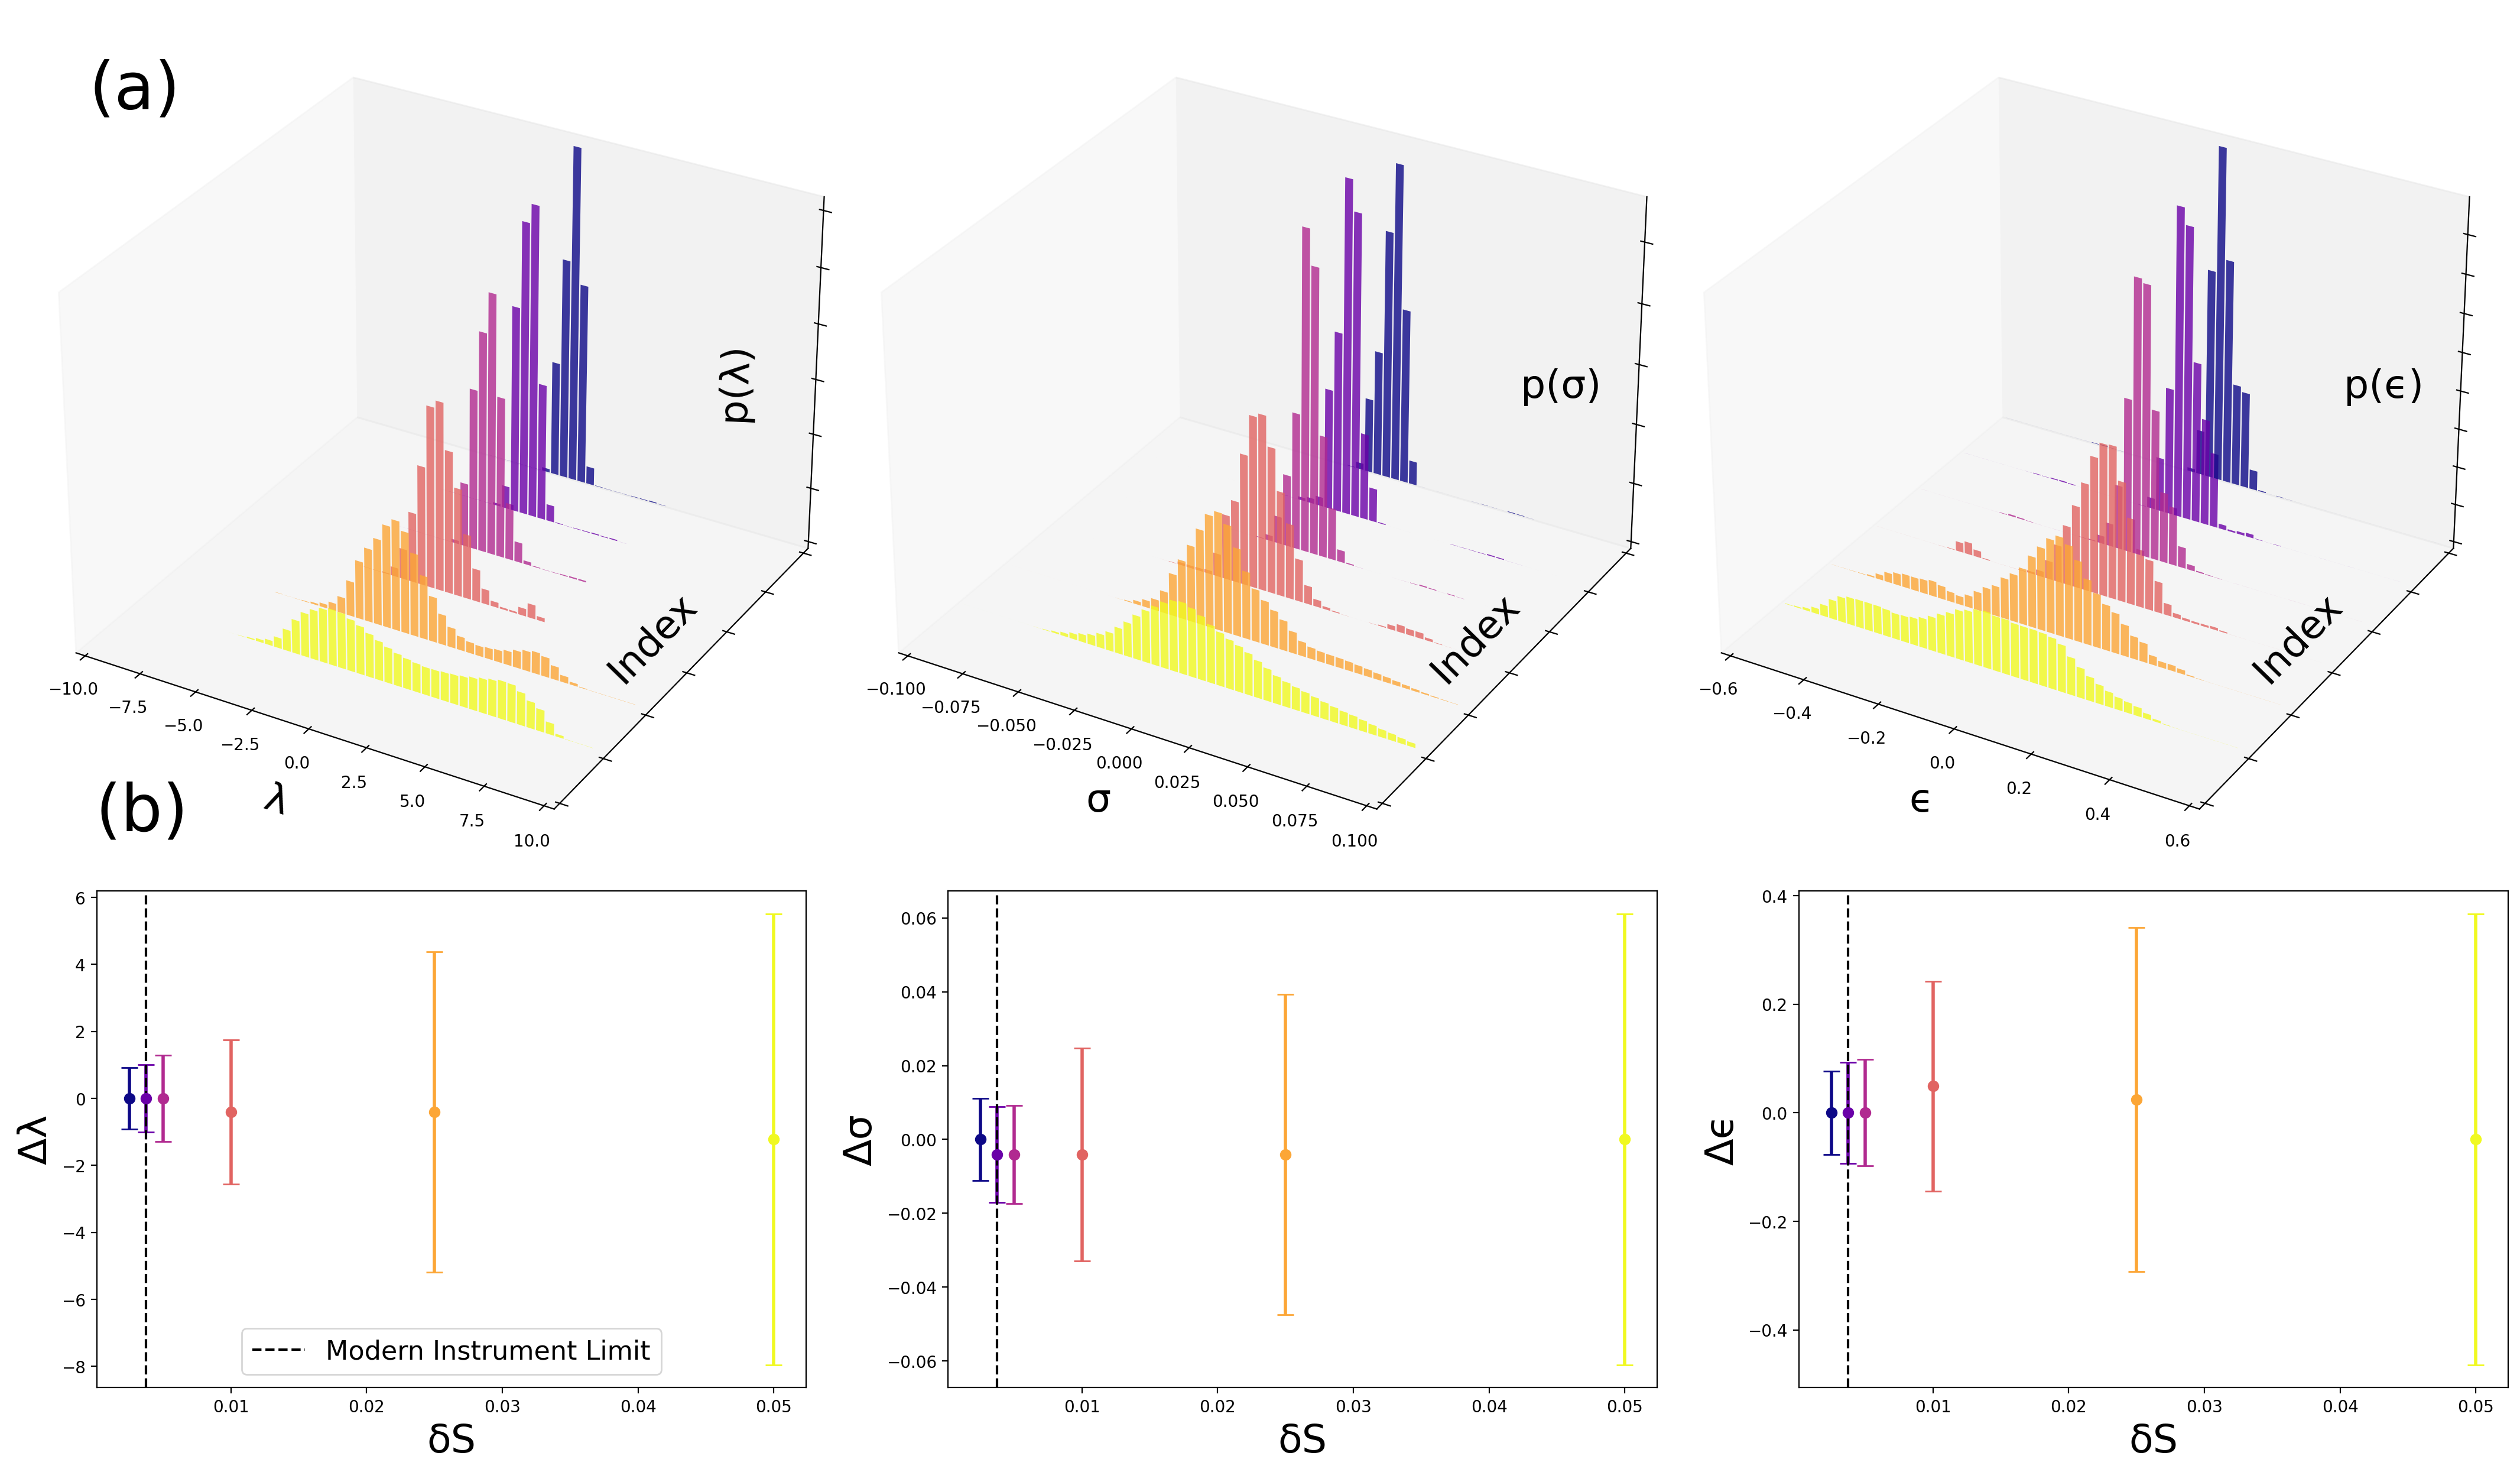

In [14]:
fig = plt.figure(figsize=(24,12))
fs = 24
positions = [
    [-0.08, 0.42, 0.5, 0.6],  # First subplot position
    [0.21, 0.42, 0.5, 0.6],  # Second subplot position
    [0.5, 0.42, 0.5, 0.6],  # Third subplot position
    [0.05, 0.05, 0.25, 0.35],   # Fourth subplot position
    [0.35, 0.05, 0.25, 0.35],   # Fifth subplot position
    [0.65, 0.05, 0.25, 0.35]    # Sixth subplot position
]

n_maps = list()
n_var = list()
ax = fig.add_subplot(positions[0],projection='3d')
for i in range (len(uncs)):
    ax.bar(midsn, n_arr[i], width=0.85*(midsn[1]-midsn[0]), alpha=0.8, zs=uncs[i], zdir='y',color = newcolors[i],)
    mode_value = np.max(n_arr[i])
    mode_index = np.argmax(n_arr[i])
    mode_category = midsn[mode_index]
    # Calculate standard deviation
    mean = np.average(midsn, weights=n_arr[i])
    n_var.append(np.average((midsn - mean)**2, weights=n_arr[i]))
    n_maps.append(mode_category)
    
ax.set_xlabel('$\lambda$', fontsize = fs,labelpad = 10)
ax.set_ylabel('Index', labelpad = -40, fontsize = fs)
ax.set_zlabel('p($\lambda$)', labelpad = -50, fontsize = fs)
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_ylim(6,0)
ax.set_xlim(-10, 10)
ax.grid(False)
ax.text(-23, 0, 0.009e-3, '(a)', fontsize = 40)

σ_maps = list()
σ_var = list()
ax1 = fig.add_subplot(positions[1],projection='3d')
for i in range (len(uncs)):
    ax1.bar(midsσ, σ_arr[i], width=0.85*(midsσ[1]-midsσ[0]), alpha=0.8, zs=uncs[i], zdir='y',color = newcolors[i],)
    mode_value = np.max(σ_arr[i])
    mode_index = np.argmax(σ_arr[i])
    mode_category = midsσ[mode_index]
    # Calculate standard deviation
    mean = np.average(midsσ, weights=σ_arr[i])
    σ_var.append(np.average((midsσ - mean)**2, weights=σ_arr[i]))
    σ_maps.append(mode_category)
ax1.set_xlabel('σ', fontsize = fs,labelpad = 10)
ax1.set_ylabel('Index', labelpad = -40, fontsize = fs)
ax1.set_zlabel('p(σ)', labelpad = -50, fontsize = fs)
ax1.set_yticklabels([])
ax1.set_zticklabels([])
ax1.set_ylim(6,0)
ax1.set_xlim(-0.1, 0.1)
ax1.grid(False)

ϵ_maps = list()
ϵ_var = list()
ax2 = fig.add_subplot(positions[2],projection='3d')
for i in range (len(uncs)):
    ax2.bar(midsϵ, ϵ_arr[i], width=0.85*(midsϵ[1]-midsϵ[0]), alpha=0.8, zs=uncs[i], zdir='y',color = newcolors[i],)
    mode_value = np.max(ϵ_arr[i])
    mode_index = np.argmax(ϵ_arr[i])
    mode_category = midsϵ[mode_index]
    # Calculate standard deviation
    mean = np.average(midsϵ, weights=ϵ_arr[i])
    ϵ_var.append(np.average((midsϵ - mean)**2, weights=ϵ_arr[i]))
    ϵ_maps.append(mode_category)
ax2.set_xlabel('ϵ', fontsize = fs,labelpad = 10)
ax2.set_ylabel('Index', labelpad = -40, fontsize = fs)
ax2.set_zlabel('p(ϵ)', labelpad = -50, fontsize = fs)
ax2.set_yticklabels([])
ax2.set_zticklabels([])
ax2.set_ylim(6,0)
ax2.set_xlim(-0.6, 0.6)
ax2.grid(False)

ax3 = fig.add_subplot(positions[3])
for i in range (len(noise_arr)):
    ax3.errorbar(np.array(noise_arr[i])/2., n_maps[i], yerr = 2*np.sqrt(n_var[i]), fmt = "o", capsize = 5, linewidth = 2, color = newcolors[i])
ax3.set_ylabel('Δ$\lambda$', fontsize = fs)
ax3.set_xlabel('δS', fontsize = fs)
ax3.axvline(0.00375, color = 'k', linestyle = '--', label = 'Modern Instrument Limit')
# ax3.axvline(0.01, color = 'k', linestyle = '--')
ax3.text(0, 8, '(b)', fontsize = 40)
ax3.legend(loc = 'best', fontsize = 16)
    
ax4 = fig.add_subplot(positions[4])
for i in range (len(noise_arr)):
    ax4.errorbar(np.array(noise_arr[i])/2., σ_maps[i], yerr = 2*np.sqrt(σ_var[i]), fmt = "o", capsize = 5, linewidth = 2, color = newcolors[i])
ax4.set_ylabel('Δσ', fontsize = fs)
ax4.set_xlabel('δS', fontsize = fs)
ax4.axvline(0.00375, color = 'k', linestyle = '--')
# ax4.axvline(0.005, color = 'k', linestyle = '--')
#ax4.legend(loc = 'upper left', fontsize = 16)

ax5 = fig.add_subplot(positions[5])
for i in range (len(noise_arr)):
    ax5.errorbar(np.array(noise_arr[i])/2., ϵ_maps[i], yerr = 2*np.sqrt(ϵ_var[i]), fmt = "o", capsize = 5, linewidth = 2, color = newcolors[i])
ax5.set_ylabel('Δϵ', fontsize = fs)
ax5.set_xlabel('δS', fontsize = fs)
ax5.axvline(0.00375, color = 'k', linestyle = '--')
# ax5.axvline(0.01, color = 'k', linestyle = '--')
plt.savefig('figures/uncdist2', dpi = 600)
plt.show()

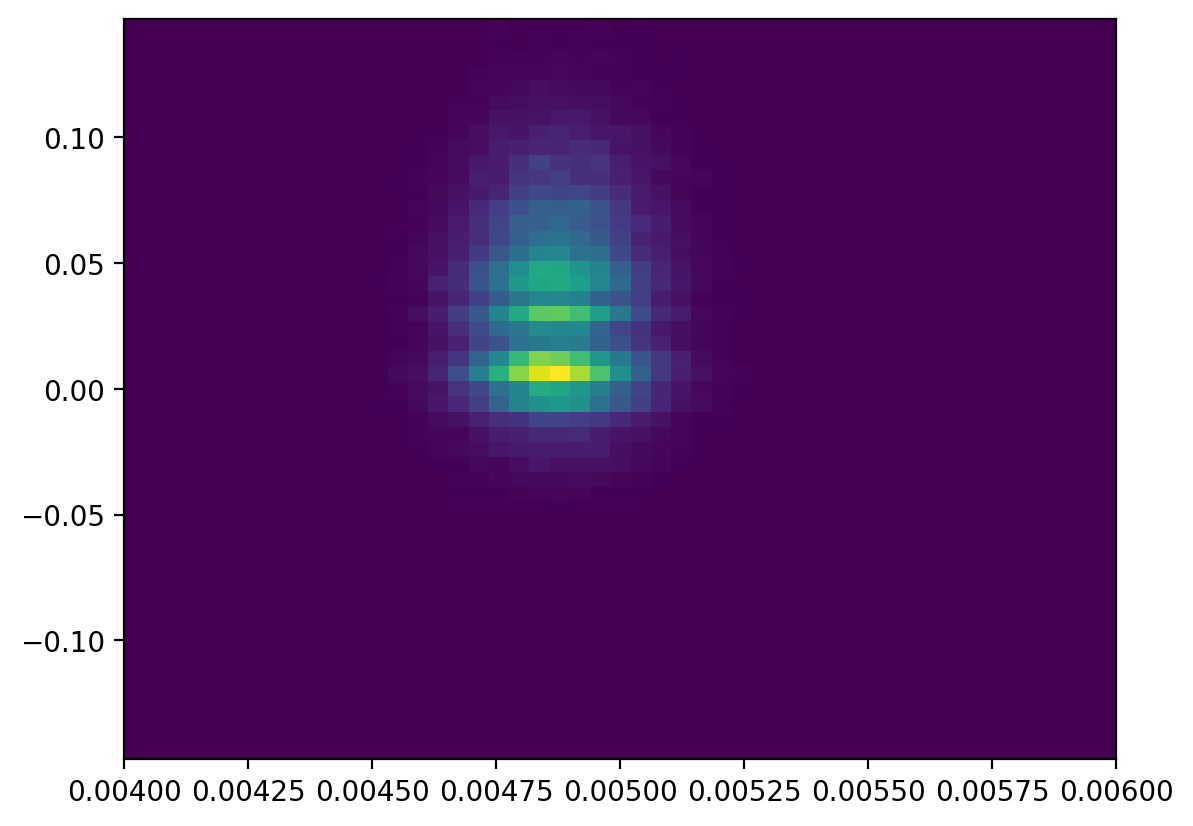

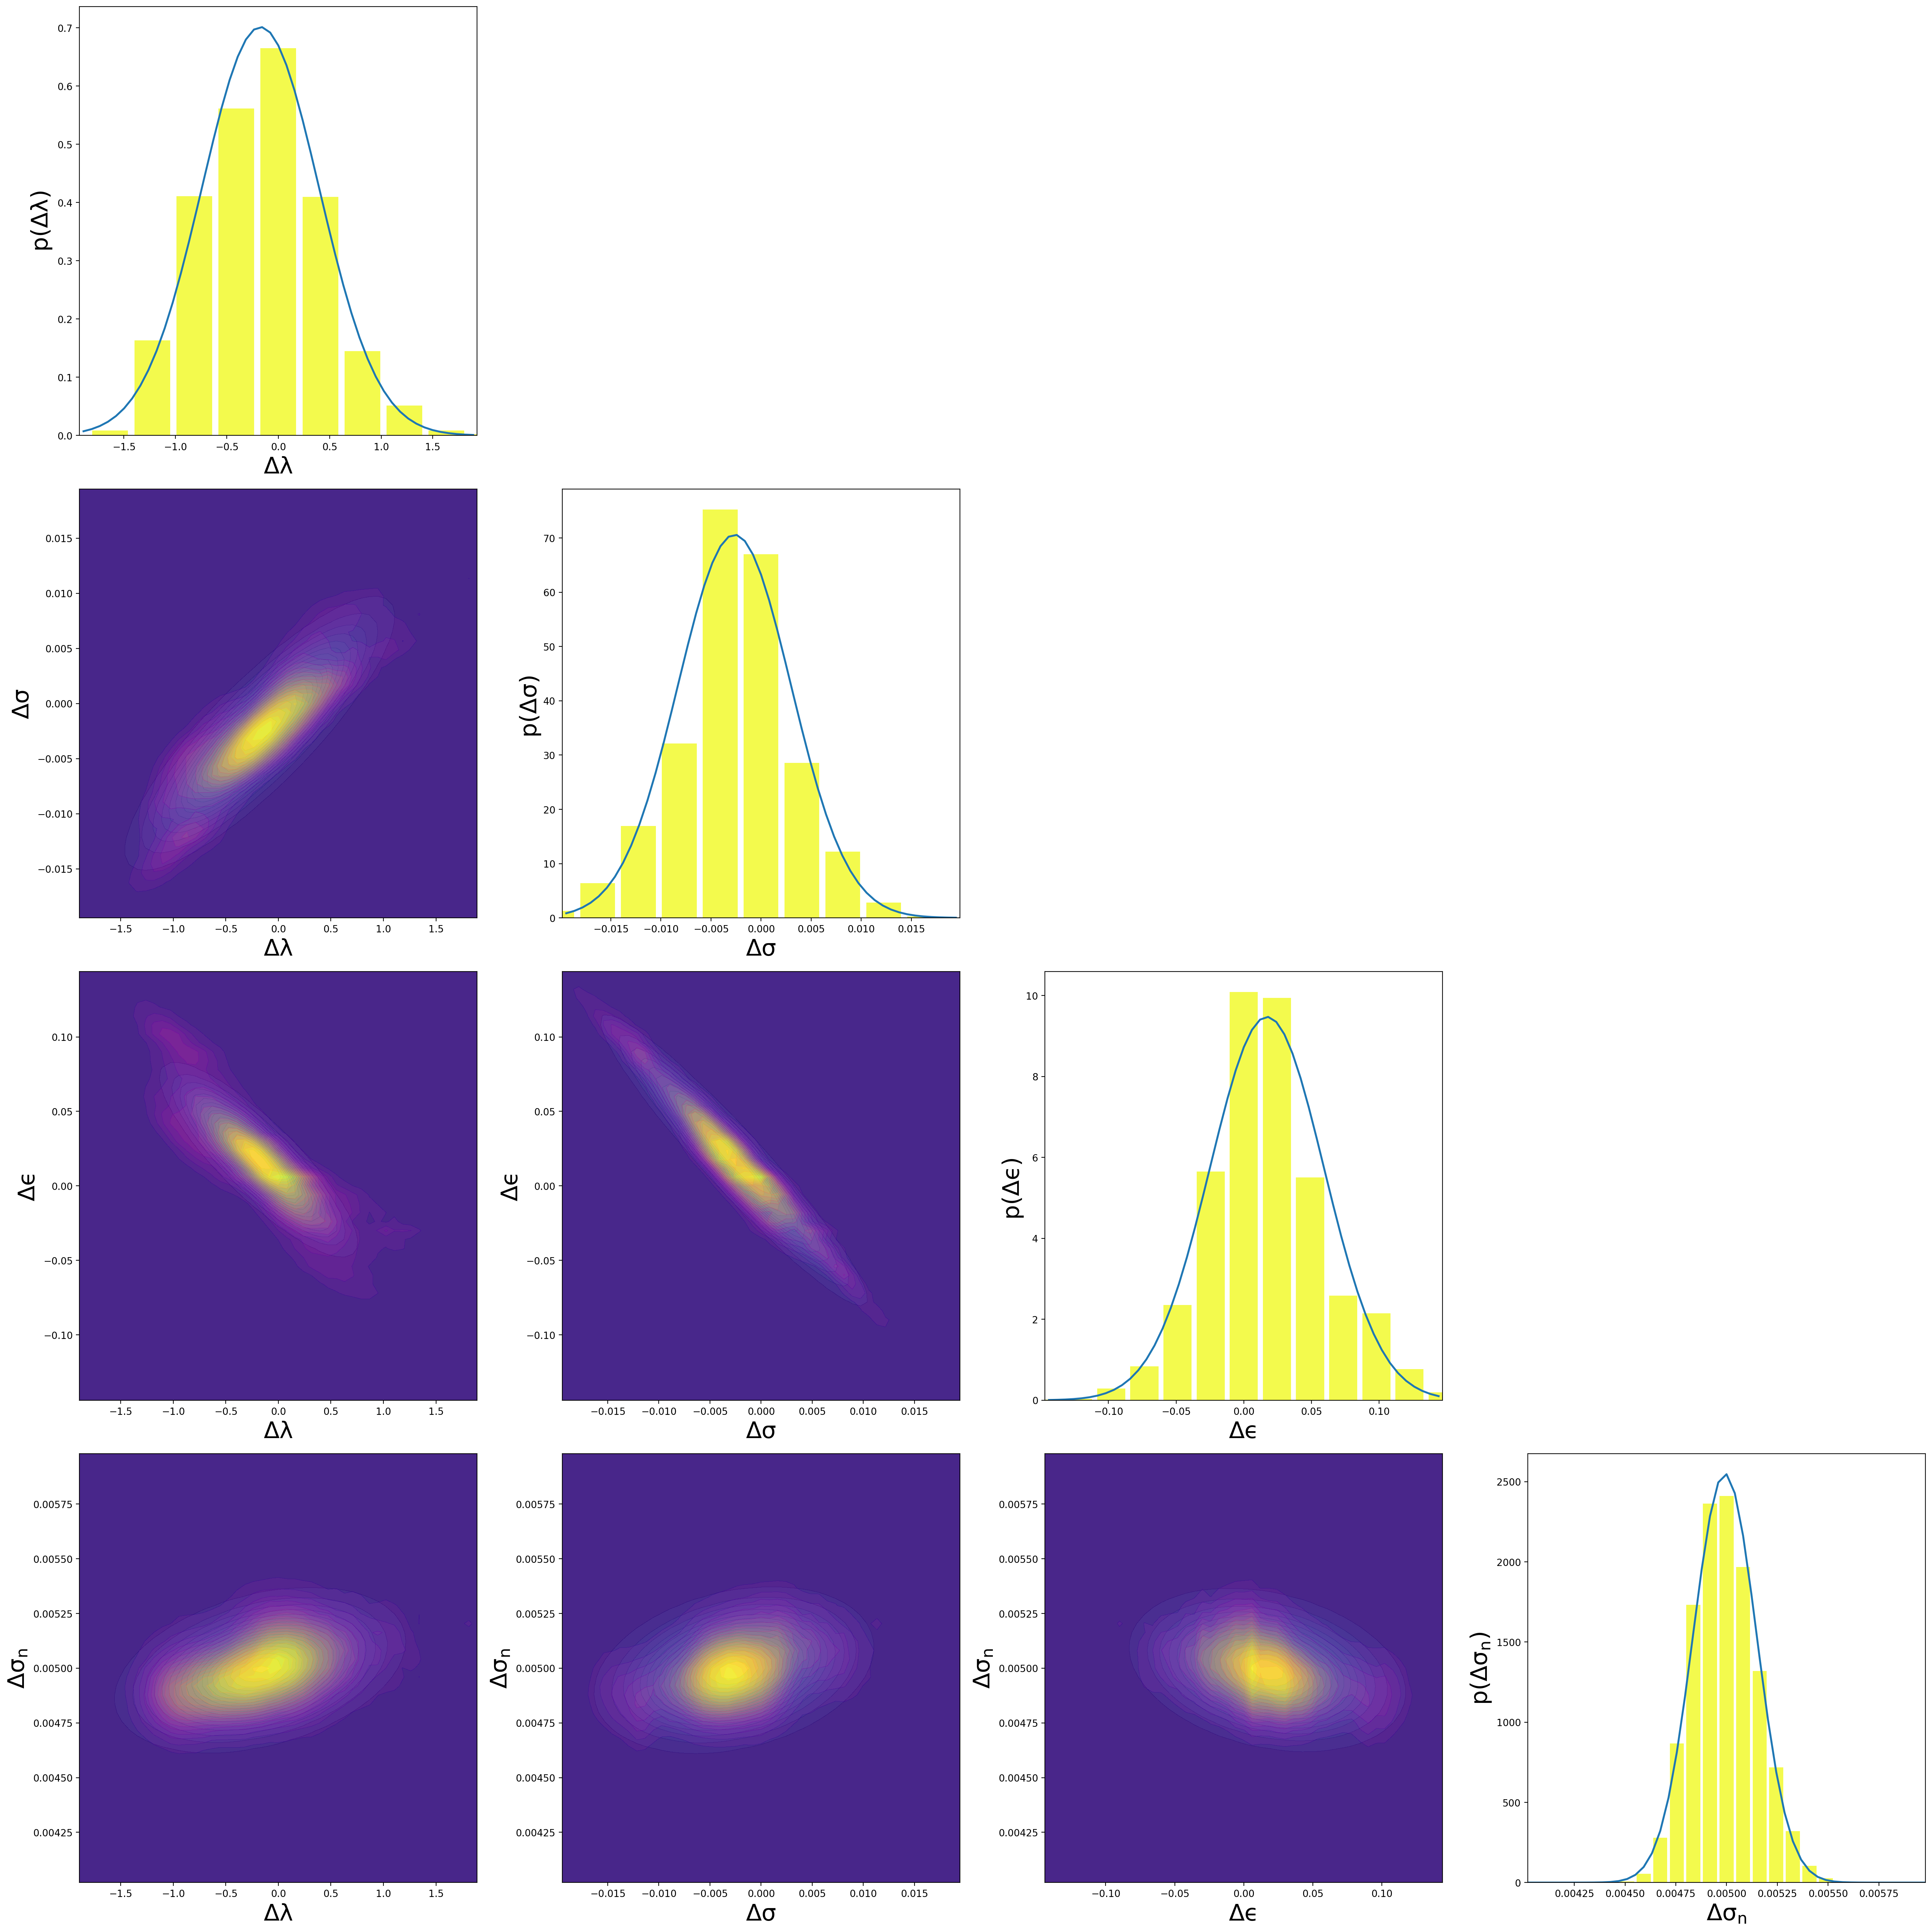

In [15]:
# Create n_edges
# Create sigma_edges
# Create eps_edges
# Create sigma_n_edges
bincount = 50
exp_index = 2
n_edges   = np.linspace(-3*np.sqrt(n_var[exp_index]),3*np.sqrt(n_var[exp_index]),bincount)
n_centers = 0.5*(n_edges[1:] + n_edges[:-1])
σ_edges  = np.linspace(-3*np.sqrt(σ_var[exp_index]),3*np.sqrt(σ_var[exp_index]),bincount)
σ_centers = 0.5*(σ_edges[1:] + σ_edges[:-1])
ϵ_edges  = np.linspace(-3*np.sqrt(ϵ_var[exp_index]),3*np.sqrt(ϵ_var[exp_index]),bincount)
ϵ_centers = 0.5*(ϵ_edges[1:] + ϵ_edges[:-1])
if exp_index <= 4:
    σn_edges = np.linspace(noise_arr[exp_index]/2 - 0.001 ,noise_arr[exp_index]/2 + 0.001,bincount)
    σn_centers = 0.5*(σn_edges[1:] + σn_edges[:-1])
if exp_index > 4:
    σn_edges = np.linspace(noise_arr[exp_index]/2 - 0.01 ,noise_arr[exp_index]/2 + 0.01,bincount)
    σn_centers = 0.5*(σn_edges[1:] + σn_edges[:-1])

mcmc_nomad = [mcmc_n,mcmc_σ,mcmc_ϵ,mcmc_σn]
# edges = Create (4,num_bins) np array

edges   = [n_edges, σ_edges, ϵ_edges, σn_edges]
centers = [n_centers, σ_centers, ϵ_centers, σn_centers]
# Store edges in above array

h_avg_all = np.zeros((4, 4, bincount-1, bincount-1))

for p1 in range(4):
    for p2 in range(4):
        if p2 < p1:
            h_avg = np.zeros((bincount-1,bincount-1))
            for j in range(len(ids)):
                # Hist2D between p1 and p2 density=False bins = predefined grid sizes and number of bins.
                h, xedges, yedges, image = plt.hist2d(mcmc_nomad[p1][exp_index][j], mcmc_nomad[p2][exp_index][j], bins=[edges[p1], edges[p2]], density = True)
                # Similar to histbins_n = np.linspace(-5, 10, 50) but on 2 parameters. Define bins b4 loops.
                h_avg += h/(len(mcmc_nomad[p1][exp_index][j]))
                # Specific argument to hist2D bins = [edges[p1], edges[p2]] 
#                 plt.show() 

                # Divide Hist2D result by number of samples for this id
            #h_avg /= len(ids)
            # Divide matrix by number of ids
            # Compute centers of bins. Maybe some fancy meshgrid fxn would do it?
            h_avg_all[p1][p2] = h_avg
#             print(np.shape(h_avg_all[p1][p2]))
#             print(p1)
#             print(p2)
#             print(np.shape(h_avg))
            # Save for l8r, both matrix and the bin centers


# # Define ax with appropriate 4,4 size
# for p1 in range(4):
#     for p2 in range(4):
#         if p2 < p1:
#             #contourf with p1 and p2 matrix and bin centers

#         if p2 == p1:
#             # plot marginal

fig, ax = plt.subplots(4, 4, figsize=(28, 28))
fig.delaxes(ax[0,1])
fig.delaxes(ax[0,2])
fig.delaxes(ax[0,3])
fig.delaxes(ax[1,2])
fig.delaxes(ax[1,3])
fig.delaxes(ax[2,3])
for p1 in range(4):
    for p2 in range(4):
        if p1 < p2:
            xv, yv = np.meshgrid(centers[p1], centers[p2])
            bin_centers = np.column_stack([xv.ravel(), yv.ravel()])
            counts = (h_avg_all[p2][p1]*1000).ravel()
            counts = counts.astype(int)
            expanded_data = np.repeat(bin_centers, counts, axis=0)
            mean_vector = np.mean(expanded_data, axis=0)
            cov_matrix = np.cov(expanded_data, rowvar=False)
            dist = multivariate_normal(mean=mean_vector, cov=cov_matrix)
            pdf_values = dist.pdf(bin_centers).reshape(xv.shape)
            ax[p2][p1].contourf(xv, yv, pdf_values, levels=20, alpha = 0.75)
            ax[p2][p1].contourf(centers[p1], centers[p2], h_avg_all[p2][p1], levels=20, alpha = 0.5, cmap='plasma')
            ax[p1][p2].set_xlabel(p1)
            ax[p1][p2].set_ylabel(p2)
    if p1 == 0 or p1 ==1 or p1 == 2:       
        ax[p1][p1].plot(centers[p1],norm.pdf(centers[p1], mean_vector[0], np.sqrt(cov_matrix[0][0])),linewidth = 2)
    if p1 == 3:       
        ax[p1][p1].plot(centers[p1],norm.pdf(centers[p1], mean_vector[1], np.sqrt(cov_matrix[1][1])),linewidth = 2)
            
ax[0][0].bar(midsn, n_arr[exp_index]*0.7e5, width=0.85*(midsn[1]-midsn[0]), alpha=0.8,color = newcolors[i],)
ax[0][0].set_xlim(-3*np.sqrt(n_var[exp_index]),3*np.sqrt(n_var[exp_index]))
ax[1][1].bar(midsσ, σ_arr[exp_index]*0.7e5, width=0.85*(midsσ[1]-midsσ[0]), alpha=0.8,color = newcolors[i],)
ax[1][1].set_xlim(-3*np.sqrt(σ_var[exp_index]),3*np.sqrt(σ_var[exp_index]))
ax[2][2].bar(midsϵ, ϵ_arr[exp_index]*0.7e5, width=0.85*(midsϵ[1]-midsϵ[0]), alpha=0.8,color = newcolors[i],)
ax[2][2].set_xlim(-3*np.sqrt(ϵ_var[exp_index]),3*np.sqrt(ϵ_var[exp_index]))
ax[3][3].bar(middies[exp_index], σn_arr[exp_index]*0.7e5, width=0.85*(middies[exp_index][1]-middies[exp_index][0]), alpha=0.8,color = newcolors[i],)

#labels
ax[0][0].set_xlabel('Δ$\lambda$', fontsize = fs)
ax[0][0].set_ylabel('p(Δ$\lambda$)', fontsize = fs)
ax[1][1].set_xlabel('Δσ', fontsize = fs)
ax[1][1].set_ylabel('p(Δσ)', fontsize = fs)
ax[2][2].set_xlabel('Δϵ', fontsize = fs)
ax[2][2].set_ylabel('p(Δϵ)', fontsize = fs)
ax[3][3].set_xlabel('Δ$σ_n$', fontsize = fs)
ax[3][3].set_ylabel('p(Δ$σ_n$)', fontsize = fs)
ax[3][3].set_xlim(centers[3][0], centers[3][-1])
ax[1][0].set_xlabel('Δ$\lambda$', fontsize = fs)
ax[1][0].set_ylabel('Δσ', fontsize = fs)
ax[2][0].set_xlabel('Δ$\lambda$', fontsize = fs)
ax[2][0].set_ylabel('Δϵ', fontsize = fs)
ax[3][0].set_xlabel('Δ$\lambda$', fontsize = fs)
ax[3][0].set_ylabel('Δ$σ_n$', fontsize = fs)
ax[2][1].set_xlabel('Δσ', fontsize = fs)
ax[2][1].set_ylabel('Δϵ', fontsize = fs)
ax[3][1].set_xlabel('Δσ', fontsize = fs)
ax[3][1].set_ylabel('Δ$σ_n$', fontsize = fs)
ax[3][2].set_xlabel('Δϵ', fontsize = fs)
ax[3][2].set_ylabel('Δ$σ_n$', fontsize = fs)
plt.tight_layout()
plt.savefig('figures/histograms', dpi = 600)
plt.show()

qmin = 1.25
qmax = 30.698908169815425
Δq = tensor(0.1253)


/var/folders/q1/9ty2s0rx2yz1wym60b_0f58c0000gn/T/ipykernel_68312/880809487.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = cm.get_cmap('plasma', len(noise_arr))


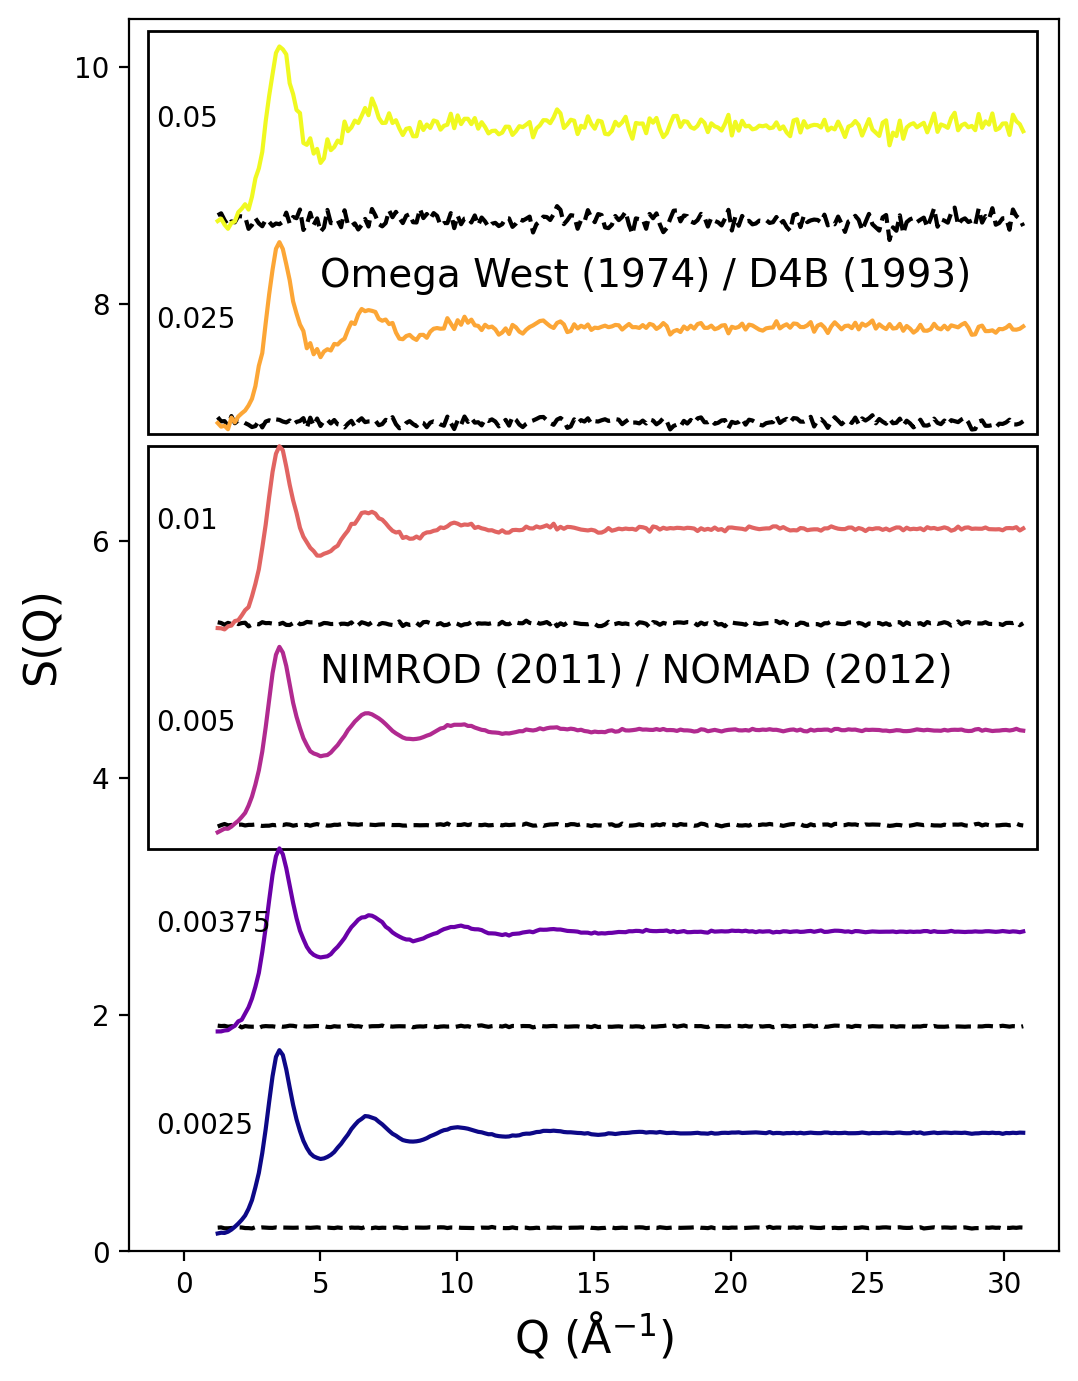

In [16]:
from matplotlib.patches import Rectangle

#assume atom size of ~2.5 A^-1
N_particles = 1_000
name = "A"
timestep = 0.0025 # 48.#### fs
kbT = 1
ρ = 0.1
nsims = 960
rmax = (0.95/2)*((N_particles/ρ)**(1/3))
rmin = 0
rnum = 250
r = np.linspace(rmin,rmax,rnum)
qmax = np.pi/(2.5*(rmax - rmin)/rnum) #qmax in reduced space is (π/Δr)*1/2.5
qmin = 1.25                           #qmin in reduced space is qmin for standard diffractometers * 2.5 A
qnum = 236                            #qnum selected so that the spacing is approximately 0.05A^{-1} for a 2.5 A particle
q = torch.linspace(qmin,qmax,qnum) 
print('qmin =', qmin)
print('qmax =', qmax)
print('Δq =', q[1]- q[0])

plasma = cm.get_cmap('plasma', len(noise_arr))
newcolors = plasma(np.linspace(0, 1, len(noise_arr)))

plt.figure(figsize = (6,8))
for j in range (len(noise_arr)):
    noise = np.random.normal(0,noise_arr[j]/2,(len(q)))
    plt.text(-1, 1 + 1.7*j, noise_arr[j]/2)
    plt.plot(q,noise+ 1.7*j + 0.2, color ='k',linestyle = '--')
    plt.plot(q, sqs_exp[1] + noise + 1.7*j, color = newcolors[j])
plt.xlabel('Q ($\AA^{-1}$)', fontsize = 16)
plt.ylabel('S(Q)', fontsize = 16)
plt.gca().add_patch(Rectangle((-1.3,6.9),32.5,3.4,
                    edgecolor='black',
                    facecolor='none',
                    lw=1))

plt.gca().add_patch(Rectangle((-1.3,3.4),32.5,3.4,
                    edgecolor='black',
                    facecolor='none',
                    lw=1))
plt.text(5,8.15, 'Omega West (1974) / D4B (1993)', fontsize = 14)
plt.text(5,4.8, 'NIMROD (2011) / NOMAD (2012)', fontsize = 14)
plt.xlim(-2,32)
plt.ylim(0,10.4)
#plt.savefig('figures/addedunc', dpi = 600)
plt.show()

In [18]:
print("Loading training data...")
input_dict = load(open('training_data/train_data.p', 'rb'))
xd = input_dict['xs']
sqs = input_dict['sqs'] 
rdfs = input_dict['rdfs']
print("Success!!!")

def se_kernel(x1, x2, l, width):
    K = width**2 * torch.exp(-(torch.cdist(x1/l,x2/l,p=2)**2)/2)
    return K

def se_dkernel(Kid,x1,x2,di,l):
    import numpy as np
    KidD = torch.zeros((len(x1), len(x2)))
    for i in range (len(x1)):
        for j in range (len(x2)):
            KidD[i][j] = Kid[i][j] *(x2[j][di] - x1[i][di])/(l[di]**2)
    return KidD

Xd = torch.tensor(xd).float()
Xi = torch.tensor([[8.0833, 1.5833, 0.1833]])
y = torch.tensor(sqs).float()

n = len(Xd)
η = len(q)

arr    = [3.38224890e+00, 1.88830504e-01, 1.16976918e-01, 1.37565712e-01, 1.37362647e-06]
l      = torch.tensor([arr[0],arr[1],arr[2]]).float()
w      = torch.tensor(arr[3]).float()
σn     = torch.tensor(arr[4]).float()
Kdd    = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*σn
KddInv = torch.linalg.inv(Kdd)

Loading training data...
Success!!!


In [ ]:
# 3 times for n,s,eps
    # some 2d tensor based on sigma grid
    # some 2d tensor based on eps grid
points = 50   
σdata_grid = torch.linspace(1.56,1.94,points)
ϵdata_grid = torch.linspace(0.14,0.96,points)
max_n_arr = torch.zeros((points,points))
max_σ_arr = torch.zeros((points,points))
max_ϵ_arr = torch.zeros((points,points))

for i in range(len(σdata_grid)):
    for j in range(len(σdata_grid)):
        Xi = torch.tensor([[16, σdata_grid[i],ϵdata_grid[j]]])

        Kid = se_kernel(Xi, Xd, l, w)
        derivKid = se_dkernel(Kid,Xi,Xd,0,l)
        KidKddInv = (derivKid @ KddInv)
        μ_n = (KidKddInv @ (y)).T
        max_n_arr[i][j] = max(abs(μ_n))

        derivKid = se_dkernel(Kid,Xi,Xd,1,l)
        KidKddInv = (derivKid @ KddInv)
        μ_σ = (KidKddInv @ (y)).T
        max_σ_arr[i][j] = max(abs(μ_σ))

        derivKid = se_dkernel(Kid,Xi,Xd,2,l)
        KidKddInv = (derivKid @ KddInv)
        μ_ϵ = (KidKddInv @ (y)).T
        max_ϵ_arr[i][j] = max(abs(μ_ϵ))
        
T_star = 1/ϵdata_grid
ρ_star = ρ*σdata_grid**3

In [ ]:
fig, ax1 = plt.subplots(2,3, figsize = (24, 12))
fs = 24

#single plots
Xi = torch.tensor([[12, σdata_grid[np.unravel_index(max_n_arr.detach().argmin(), max_n_arr.detach().shape)[0]],
                    ϵdata_grid[np.unravel_index(max_n_arr.detach().argmin(), max_n_arr.detach().shape)[1]]]])
Kid = se_kernel(Xi, Xd, l, w)
derivKid = se_dkernel(Kid,Xi,Xd,0,l)
KidKddInv = (derivKid @ KddInv)
μ_nmin = (KidKddInv @ (y)).T

Xi = torch.tensor([[12, σdata_grid[np.unravel_index(max_σ_arr.detach().argmin(), max_σ_arr.detach().shape)[0]],
                    ϵdata_grid[np.unravel_index(max_σ_arr.detach().argmin(), max_σ_arr.detach().shape)[1]]]])
derivKid = se_dkernel(Kid,Xi,Xd,1,l)
KidKddInv = (derivKid @ KddInv)
μ_σmin = (KidKddInv @ (y)).T

Xi = torch.tensor([[12, σdata_grid[np.unravel_index(max_ϵ_arr.detach().argmin(), max_ϵ_arr.detach().shape)[0]],
                    ϵdata_grid[np.unravel_index(max_ϵ_arr.detach().argmin(), max_ϵ_arr.detach().shape)[1]]]])
derivKid = se_dkernel(Kid,Xi,Xd,2,l)
KidKddInv = (derivKid @ KddInv)
μ_ϵmin = (KidKddInv @ (y)).T

Xi = torch.tensor([[12, σdata_grid[np.unravel_index(max_n_arr.detach().argmax(), max_n_arr.detach().shape)[0]],
                    ϵdata_grid[np.unravel_index(max_n_arr.detach().argmax(), max_n_arr.detach().shape)[1]]]])
Kid = se_kernel(Xi, Xd, l, w)
derivKid = se_dkernel(Kid,Xi,Xd,0,l)
KidKddInv = (derivKid @ KddInv)
μ_nmax = (KidKddInv @ (y)).T

Xi = torch.tensor([[12, σdata_grid[np.unravel_index(max_σ_arr.detach().argmax(), max_σ_arr.detach().shape)[0]],
                    ϵdata_grid[np.unravel_index(max_σ_arr.detach().argmax(), max_σ_arr.detach().shape)[1]]]])
derivKid = se_dkernel(Kid,Xi,Xd,1,l)
KidKddInv = (derivKid @ KddInv)
μ_σmax = (KidKddInv @ (y)).T

Xi = torch.tensor([[12, σdata_grid[np.unravel_index(max_ϵ_arr.detach().argmax(), max_ϵ_arr.detach().shape)[0]],
                    ϵdata_grid[np.unravel_index(max_ϵ_arr.detach().argmax(), max_ϵ_arr.detach().shape)[1]]]])
derivKid = se_dkernel(Kid,Xi,Xd,2,l)
KidKddInv = (derivKid @ KddInv)
μ_ϵmax = (KidKddInv @ (y)).T


ax1[0,0].set_xlabel('Q (Å$^{-1}$)')
ax1[0,0].set_ylabel('$\partial S/\partial n$')
ax1[0,0].plot(q, μ_nmin - μ_nmin[-1], label = 'Der. @ Min.')
ax1[0,0].plot(q, μ_nmax - μ_nmax[-1], label = 'Der. @ Min.')
ax1[0,0].tick_params(axis='y')
ax1[0,0].set_ylim(-0.009, 0.009)
ax2 = ax1[0,0].twinx()  # instantiate a second Axes that shares the same x-axis
ax2.plot(q,sqs_exp[0]-1, color='k')
ax2.set_ylim(-0.7, 0.7)
ax2.axis('off')

ax1[0,1].set_xlabel('Q (Å$^{-1}$)')
ax1[0,1].set_ylabel('$\partial S/\partial σ$')
ax1[0,1].plot(q, μ_σmin - μ_σmin[-1])
ax1[0,1].plot(q, μ_σmax - μ_σmax[-1])
ax1[0,1].set_ylim(-4,4)
ax2 = ax1[0,1].twinx()  # instantiate a second Axes that shares the same x-axis
ax2.plot(q,sqs_exp[0]-1, color='k', label = 'Structure Factor', linestyle = '--')
ax2.tick_params(axis='y', labelcolor='k')
ax2.set_ylim(-0.7, 0.7)

ax1[0,2].set_xlabel('Q (Å$^{-1}$)')
ax1[0,2].set_ylabel('$\partial S/\partial ϵ$')
ax1[0,2].plot(q, μ_ϵmin- μ_ϵmin[-1])
ax1[0,2].plot(q, μ_ϵmax- μ_ϵmax[-1])
ax1[0,2].set_ylim(-20,20)
ax2 = ax1[0,2].twinx()  # instantiate a second Axes that shares the same x-axis
ax2.plot(q,sqs_exp[0]-1, color='k')
ax2.set_ylim(-0.7, 0.7)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('derivs', dpi = 600)
plt.show()


In [ ]:
fig, ax1 = plt.subplots(2,3, figsize = (24, 12))
spline_points = 25
markersize = 75
x_new = np.linspace(ρ_vle[0],ρ_vle[-1],spline_points)
spl_map = make_interp_spline(ρ_vle, T_vle, k=2)
y_map_smooth = spl_map(x_new)
fs = 24
contour1 = ax1[0,0].contourf(ρ_star, T_star, max_n_arr.detach(),alpha = 0.75)
ax1[0,0].fill_between(x_new, 0, y_map_smooth, color = 'gray', alpha = 0.8)
ax1[0,0].scatter(ρ_vle, T_vle, color = 'r', s = markersize)
ax1[0,0].plot(x_new, y_map_smooth, color = 'r')
ax1[0,0].set_xlabel('ρ$^*$', fontsize = fs)
ax1[0,0].set_ylabel('$T^*$', fontsize = fs)
ax1[0,0].set_xlim(ρ_star[0], ρ_star[-1])
ax1[0,0].set_ylim(T_star[-1], T_star[0])
ax1[0,0].text(0.25, 5, '(a)', fontsize = 40)

contour2 = ax1[0,1].contourf(ρ_star, T_star, max_σ_arr.detach(),alpha = 0.75)
ax1[0,1].fill_between(x_new, 0, y_map_smooth, color = 'gray', alpha = 0.8)
ax1[0,1].scatter(ρ_vle, T_vle, color = 'r', s = markersize)
ax1[0,1].plot(x_new, y_map_smooth, color = 'r')
ax1[0,1].set_xlabel('ρ$^*$', fontsize = fs)
ax1[0,1].set_ylabel('$T^*$', fontsize = fs)
ax1[0,1].set_xlim(ρ_star[0], ρ_star[-1])
ax1[0,1].set_ylim(T_star[-1], T_star[0])

contour3 = ax1[0,2].contourf(ρ_star, T_star, max_ϵ_arr.detach(),alpha = 0.75)
ax1[0,2].fill_between(x_new, 0, y_map_smooth, color = 'gray', alpha = 0.8)
ax1[0,2].scatter(ρ_vle, T_vle, color = 'r', s = markersize)
ax1[0,2].plot(x_new, y_map_smooth, color = 'r')
ax1[0,2].set_xlabel('ρ$^*$', fontsize = fs)
ax1[0,2].set_ylabel('$T^*$', fontsize = fs)
ax1[0,2].set_xlim(ρ_star[0], ρ_star[-1])
ax1[0,2].set_ylim(T_star[-1], T_star[0])

contour4 = ax1[1,0].contourf(ρ_star, T_star, max_n_arr.detach(),alpha = 0.75)
ax1[1,0].fill_between(x_new, 0, y_map_smooth, color = 'gray', alpha = 0.8)
ax1[1,0].scatter(np.array(exp_params).T[1], np.array(exp_params).T[2], color = 'white', label = 'Exp. Parameters')
ax1[1,0].set_xlabel('ρ$^*$', fontsize = fs)
ax1[1,0].set_ylabel('$T^*$', fontsize = fs)
ax1[1,0].scatter(ρ_vle, T_vle, color = 'r', s = markersize, label = 'Sat. Liquid Line')
ax1[1,0].plot(x_new, y_map_smooth, color = 'r')
ax1[1,0].set_xlim(ρ_star[0], ρ_star[-1])
ax1[1,0].set_ylim(T_star[-1], 1.5)
ax1[1,0].text(0.25, 1.35, '(b)', fontsize = 40)
ax1[1,0].text(0.4, 1.15, 'Metastable', fontsize = 24)
ax1[1,0].legend(loc = 'upper left', fontsize = 16)

contour5 = ax1[1,1].contourf(ρ_star, T_star, max_σ_arr.detach(),alpha = 0.75)
ax1[1,1].fill_between(x_new, 0, y_map_smooth, color = 'gray', alpha = 0.8)
ax1[1,1].scatter(np.array(exp_params).T[1], np.array(exp_params).T[2], color = 'white', label = 'Exp. Parameters')
ax1[1,1].set_xlabel('ρ$^*$', fontsize = fs)
ax1[1,1].set_ylabel('$T^*$', fontsize = fs)
ax1[1,1].scatter(ρ_vle, T_vle, color = 'r', s = markersize, label = 'Sat. Liquid Line')
ax1[1,1].plot(x_new, y_map_smooth, color = 'r')
ax1[1,1].set_xlim(ρ_star[0], ρ_star[-1])
ax1[1,1].set_ylim(T_star[-1], 1.5)
ax1[1,1].text(0.4, 1.15, 'Metastable', fontsize = 24)

contour6 = ax1[1,2].contourf(ρ_star, T_star, max_ϵ_arr.detach(),alpha = 0.75)
ax1[1,2].fill_between(x_new, 0, y_map_smooth, color = 'gray', alpha = 0.8)
ax1[1,2].scatter(np.array(exp_params).T[1], np.array(exp_params).T[2], color = 'white')
ax1[1,2].set_xlabel('ρ$^*$', fontsize = fs)
ax1[1,2].set_ylabel('$T^*$', fontsize = fs)
ax1[1,2].scatter(ρ_vle, T_vle, color = 'r', s = markersize)
ax1[1,2].plot(x_new, y_map_smooth, color = 'r')
ax1[1,2].set_xlim(ρ_star[0], ρ_star[-1])
ax1[1,2].set_ylim(T_star[-1], 1.5)
ax1[1,2].text(0.4, 1.15, 'Metastable', fontsize = 24)

fig.colorbar(contour1, ax=ax1[0,0])
fig.colorbar(contour2, ax=ax1[0,1])
fig.colorbar(contour3, ax=ax1[0,2])
fig.colorbar(contour4, ax=ax1[1,0])
fig.colorbar(contour5, ax=ax1[1,1])
fig.colorbar(contour6, ax=ax1[1,2])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('figures/phasediagderivs', dpi = 600)
plt.show()